# Lesson 3 Assignment - Monty Hall Simulation
## Author - AlexSkrn

### Instructions
Simulate the conditional probabilities of the distributions for winning a car vs. a goat for the Monty Hall Problem that includes the following:
1. the cases for switching or not switching
2. histograms and summary statistics (at least mean and variance) of the results for winning the car or a goat for both strategies: switching or not switching
3. comparison of the cases to determine the best strategy
4. recommended strategy



#### Note: 
Please clearly outline the results and your recommendation with markdown text. Be sure your discussion includes narrative for your figures and tables so it is clear to the reader the importance of each bit of evidence.

## Contents<a id='contents'></a>

[1. Narrative part](#1)

   [1.1. Game rules and assumptions](#1.1)

   [1.2. Theoretical conclusion to be confirmed by the simulation](#1.2)

   [1.3. Recommended strategy](#1.3)

[2. Coding part](#2)

   [2.1. Simulate the car's and player's doors](#2.1)

   [2.2. Simulate the host's door](#2.2)

   [2.3. Simulate switch/stay results](#2.3)

   [2.4. Putting it all together (1) - Simulate many game instances](#2.4)

   [2.5. Putting it all together (2) - Running many simulations](#2.5)

# 1. Narrative part<a id='1'></a>

## 1.1. Game rules and assumptions<a id='1.1'></a>

- 3 closed doors - one prize behind a random door
- Player chooses 1 door randomly
- Host always opens that one of the two other doors which has no prize
- Player may switch or stay - Two strategies to model: **Always Stay** and **Always Switch** 

## 1.2. Theoretical conclusion to be confirmed by the simulation<a id='1.2'></a>
#### In general, long-term outcomes of the game depend on the game state and the player's switch-or-stay strategy and can be summarized like this:

| Game State | Switch | Stay |
-- | --- | ---|
Door_Prize == Door_Player |  Loss | **Win**  |
Door_Prize != Door_Player |  **Win**  | Loss |

In other words, the Switch Strategy wins in all cases where the initial choice was wrong. 

#### There are 9 potential cases in total (3 ways to insert the prize * 3 ways to choose the door). Their outcomes are as follows:

| Door_Prize | Door_Player | Door_Host | Switch | Stay |
--- | --- | --- | --- | ---
1 | 1 | 2 or 3 | Loss | **Win**
1 | 2 | 3 | **Win** | Loss
1 | 3 | 2 | **Win** | Loss
2 | 1 | 3| **Win** | Loss
2 | 2 | 1 or 3 | Loss | **Win**
2 | 3 | 1 | **Win** | Loss
3 | 1 | 2 | **Win** | Loss
3 | 2 | 1| **Win** | Loss
3 | 3 | 1 or 2 | Loss | **Win**

By counting, there are only 3 ways out of 9 possible outcomes in which the Stay Strategy wins. So, the probability of winning with the **Switch** Strategy is **2/3** and the probability of winning with the **Stay** Strategy is **1/3**.

[Go to Contents](#contents)

## 1.3. Recommended strategy<a id='1.3'></a>

The recommended strategy is **always switch**. As demonstrated in section [2.5. (_Putting it all together (2) - Running many simulations_)](#2.5), the average number of wins for the always-switch strategy is very close to the theoretical average of 2/3, with the standard deviation of the means of 1000 trials of 100 games each of about 0.05 and with a 95% confidence interval of about (0.57, 0.76), while the always-stay strategy is successful only in about 1/3 of the cases on average.

[Go to Contents](#contents)

# 2. Coding part<a id='2'></a>

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn

# Configure default plot style
seaborn.set_palette('muted')
seaborn.set_style('ticks')
%matplotlib inline

## 2.1. Simulate the car's and player's doors<a id='2.1'></a>

I will use the **discrete uniform distribution** provided by ``numpy.random.randint()`` to simulate the random number of the door behind which the car is placed and the random number of the door chosen by the player.

[Go to Contents](#contents)

In [2]:
def sim_doors(num_games):
    """Return a df with many cases for car location and player's choice."""
    doors_cars = np.random.randint(3, size = num_games)
    doors_player = np.random.randint(3, size = num_games)
    doors = pd.DataFrame({'door_car': doors_cars, 
                          'door_player': doors_player}
                        )
    return doors

# An example with 5 games, 1 game state per row
game_df = sim_doors(5)
game_df

,door_car,door_player
0,1,1
1,0,0
2,2,1
3,0,2
4,0,0


## 2.2. Simulate the host's door<a id='2.2'></a>

The host's actions are pre-determined when the player chooses a wrong door. But when the player chooses the right door, for example, door 1 is right and the player chooses it, the host opens randomly one of the two remaining non-winning doors, in this case, door # 2 or # 3.

In fact, I don't need to simulate the host, because it does not affect the ultimate simulation results, but I do this for the sake of completeness.

[Go to Contents](#contents)

In [3]:
# A helper function which will be used later as a parameter for the pandas'
# dataframe apply() method in my function sim_host()
def get_host_choice(case):
    """Given a one-case game df, return the door # which the host opens."""
    doors_choice = [0, 1, 2]
    car_door = int(case['door_car'])
    player_door = int(case['door_player'])
    
    # If the player chose the right door, the host opens randomly
    # one of the two other doors
    if car_door == player_door:
        # Get two vacant doors
        vac_doors = [i for i in doors_choice if i != car_door]
        # Choose randomly 1 of the 2 remaining non-winning doors
        return int(np.random.choice(vac_doors, 1, p = [0.5, 0.5]))
    
    # If the player chose a wrong door, the host open the only available
    # door left which door has a goat behind it
    if car_door != player_door:
        taken_doors = [int(car_door), (player_door)]
        return [i for i in doors_choice if i not in taken_doors][0]

The  following cell contains several tests for the function `get_host_choice()`

In [4]:
# Tests for the random portion of the function get_host_choice()
# The car is behind the door which the player chooses
simple_test_df = pd.DataFrame({'door_car': [0, 1, 2], 
                               'door_player': [0, 1, 2]})
res = get_host_choice(simple_test_df[0:1])  # Case 1: door 0 taken
assert res == 1 or res == 2     # Host must open 1 or 2
res = get_host_choice(simple_test_df[1:2])  # Case 2: door 1 taken
assert res == 0 or res == 2     # Host must open 0 or 3
res = get_host_choice(simple_test_df[2:3])  # Case 3: door 2 taken
assert res == 0 or res == 1     # Host must open 0 or 1

# Tests for the deterministic portion of get_host_choice()
# Host has no choice in deciding which door to open
simple_test_df = pd.DataFrame({'door_car': [0, 0, 1, 1, 2, 2], 
                               'door_player': [1, 2, 0, 2, 0, 1]})
min = 0  # A counter for the while loop and an indexer for the df
max = len(simple_test_df)
expected = [2, 1, 2, 0, 1, 0]  # Choices that the host must make
while min < max:
    res = get_host_choice(simple_test_df[min:min+1])
    assert res == expected[min]
    min += 1

The function `sim_host()` will make use of the function `get_host_choice()` above to add the door that the host will open to the dataframe.

In [5]:
def sim_host(df):
    """Add the host-opened door # to the df."""
    df['door_host'] = df.apply(get_host_choice, axis=1)
    
    return df

game_df = sim_host(game_df)
game_df

,door_car,door_player,door_host
0,1,1,0
1,0,0,2
2,2,1,0
3,0,2,1
4,0,0,2


## 2.3. Simulate switch/stay results<a id='2.3'></a>

Now I will add 2 more columns to the dataframe - switch and stay startegy outcomes. This will implement the general logic presented at the beginning of this notebook, namely:

| Game State | Switch | Stay |
-- | --- | ---|
Door_Prize == Door_Player |  Loss | **Win**  |
Door_Prize != Door_Player |  **Win**  | Loss |

The above logic assumes that the host does what he must. And as long as this is true, the host's choice is not needed in the simulation. Moreover, I don't actually need the Stay column because it is the opposite of Switch, but I'll add it for convenience.

[Go to Contents](#contents)

In [6]:
def sim_win(df):
    """Return df with 2 added columns for wins in switch/stay strategies."""
    df = df.assign(switch = (df.door_car != df.door_player).astype(int),
                   stay = (df.door_car == df.door_player).astype(int)
                  )
    return df

game_df = sim_win(game_df)
game_df

,door_car,door_player,door_host,switch,stay
0,1,1,0,0,1
1,0,0,2,0,1
2,2,1,0,1,0
3,0,2,1,1,0
4,0,0,2,0,1


## 2.4. Putting it all together (1) - Simulate many game instances<a id='2.4'></a>

Here I will run many realizations of the game before combining multiple realizations into groups called replicas.

[Go to Contents](#contents)

In [7]:
def sim_mult_games(num_games):
    """Return a df with mupliple game states and their results"""
    df = sim_doors(num_games)
    df = sim_host(df)
    df = sim_win(df)
    
    return df

# A small example with 10 games to see that it works
game = sim_mult_games(10)
game.head()

,door_car,door_player,door_host,switch,stay
0,0,1,2,1,0
1,1,2,0,1,0
2,2,2,1,0,1
3,1,1,2,0,1
4,0,0,1,0,1


In [8]:
# View results for a 100-game simulation
multi_game = sim_mult_games(100)
mean_wins = pd.DataFrame({'strategy': ['switch', 'stay'],
                          'means': [multi_game.switch.mean(), 
                                    multi_game.stay.mean()]
                         }
                        )
mean_wins

,strategy,means
0,switch,0.62
1,stay,0.38


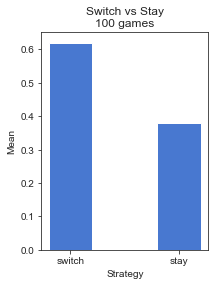

In [9]:
# Vizualize the average number of wins by strategy for 100 games
fig = plt.figure(figsize = (3, 4))
plt.bar(mean_wins.loc[:, 'strategy'], 
        mean_wins.loc[:, 'means'], 
        width = 0.4, 
        align = 'center')
plt.title('Switch vs Stay\n100 games')
plt.xlabel('Strategy')
plt.ylabel('Mean')
plt.xticks(rotation = 0);

Next I will create several simulation replicas, each one containing many instances of the game. Then I will present the results in the form of a dataframe which, for every simulation replica, contains the mean of the wins by strategy.

In [10]:
def sim_wins_replicas(n_replicas, num_games):
    """Return a df with many sim replicas for mean wins by strategy."""
    all_runs = []
    for replica_i in range(n_replicas):
        multi_game = sim_mult_games(num_games)
        single_run = pd.DataFrame({'strategy': ['switch', 'stay'],
                                   'mean_wins': [multi_game.switch.mean(), 
                                                 multi_game.stay.mean()]
                                  }
                                 )
        single_run['replica_i'] = replica_i
        all_runs.append(single_run)
        
    return pd.concat(all_runs)

# A two-replica (100 games each) example to see that the code works
replicas = sim_wins_replicas(n_replicas = 2, num_games = 100)
replicas

,strategy,mean_wins,replica_i
0,switch,0.74,0
1,stay,0.26,0
0,switch,0.61,1
1,stay,0.39,1


The above was a small example to see that the code works. In the following section, I will run many simulations.

[Go to Contents](#contents)

## 2.5. Putting it all together (2) - Running many simulations<a id='2.5'></a>

Here I will run many replicas of the simulation and plot the results, together with the **mean** and **standard deviation** of the means of many replicas of the simulation. I will also try to construct a **95% confidence interval for the mean value of the wins in the switch strategy**.

[Go to Contents](#contents)

In [11]:
num_runs = 1000
games_per_run = 100
replicas = sim_wins_replicas(n_replicas = num_runs, num_games = games_per_run)

In [12]:
print('Standard deviations:\n', replicas.groupby('strategy').mean_wins.std())
print()
print('Means:\n', replicas.groupby('strategy').mean_wins.mean())

Standard deviations:
 strategy
stay      0.048926
switch    0.048926
Name: mean_wins, dtype: float64

Means:
 strategy
stay      0.33528
switch    0.66472
Name: mean_wins, dtype: float64


**For a large number of runs, such as 1000 trials of 100 games each, the mean number of wins for the Switch strategy is very close to the theoretical mean of 0.6667 (or 2/3), while the mean number of wins for the Stay strategy is very close to 1/3.**

[Go to Contents](#contents)

In the following cell I try to calculate a **95% confidence interval for the mean value of the wins in the switch strategy**.

In [13]:
# Confidence interval for the mean of wins in the switch strategy
mu = replicas.groupby('strategy').mean_wins.mean().switch
sd = replicas.groupby('strategy').mean_wins.std().switch
conf_int_t = stats.t.interval(alpha = 0.95,           # Confidence level
                              df = num_runs - 1,      # Degrees of freedom
                              loc = mu,               # Sample mean
                              scale = sd)             # Sample standard deviation
print('Mean of the wins for the switch strategy')
print("95% confidence interval for {} trials of {} games each\n(using t-value):"
      .format(num_runs, games_per_run))
print('({:.3}, {:.3})'.format(conf_int_t[0], conf_int_t[1]))

Mean of the wins for the switch strategy
95% confidence interval for 1000 trials of 100 games each
(using t-value):
(0.569, 0.761)


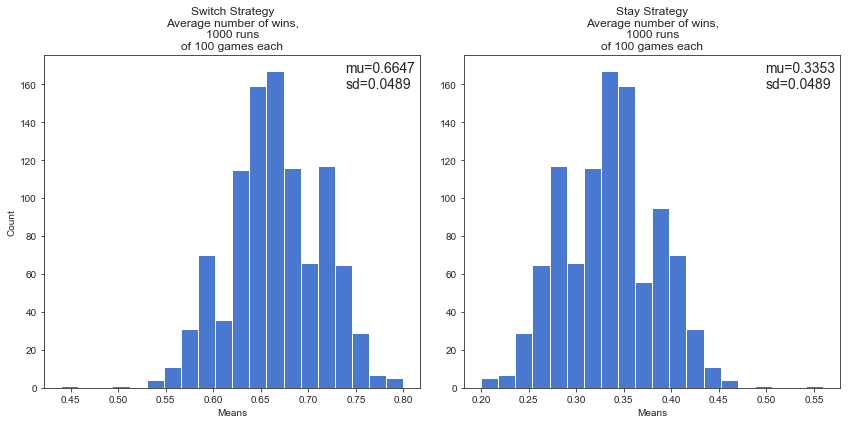

In [14]:
# Plotting means of samples (i.e. replicas) by strategy
# Select sub-sets of the dataframe by strategy
switch_win_means = replicas[(replicas.loc[:, 'strategy'] == 'switch')]
stay_win_means = replicas[(replicas.loc[:, 'strategy'] == 'stay')]

# Calculate the std and mean of the means for the switch strategy
switch_sd = switch_win_means.loc[:, 'mean_wins'].std()
switch_mu = switch_win_means.loc[:, 'mean_wins'].mean()
switch_textstr = 'mu={}\nsd={}'.format(round(switch_mu, 4), round(switch_sd, 4))

# Calculate the std and mean of the means for the stay strategy
stay_sd = stay_win_means.loc[:, 'mean_wins'].std()
stay_mu = stay_win_means.loc[:, 'mean_wins'].mean()
stay_textstr = 'mu={}\nsd={}'.format(round(stay_mu, 4), round(stay_sd, 4))

# Define 2 plots, one for each strategy
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
ax0, ax1 = axes.flat

ax0.hist(switch_win_means.loc[:, 'mean_wins'], bins = 20)
ax0.set_title('Switch Strategy\nAverage number of wins,\n{} runs\nof {} games each'
              .format(num_runs, games_per_run))
ax0.set_xlabel('Means')
ax0.set_ylabel('Count')
ax0.text(.8, .9, switch_textstr, fontsize = 14, transform = ax0.transAxes)

ax1.hist(stay_win_means.loc[:, 'mean_wins'], bins = 20)
ax1.set_title('Stay Strategy\nAverage number of wins,\n{} runs\nof {} games each'
              .format(num_runs, games_per_run))
ax1.set_xlabel('Means')
ax1.text(.8, 0.9, stay_textstr, fontsize = 14, transform = ax1.transAxes)

plt.tight_layout()
plt.show()